Pricing by simulation method + Variance reduction

In [116]:
class Call:
    import numpy as np
    
    def __init__(self, S0, K, T, sigma, r, Nmc):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.Nmc= Nmc
        
    def pay_off(s,k):
        return max(s-k,0)
    
    def price(self, type = 'naive', confidence_level = 0.95):
        from scipy.stats import norm
        
        N = len(self.S0)
        w = np.random.normal(size = (self.Nmc,N))*self.T**0.5
        V = np.zeros((N, 1))
        lower_interval = np.zeros((N, 1))
        upper_interval = np.zeros((N, 1))
        
        if type == 'naive':
            p = np.zeros((self.Nmc, N))
            for i in range(0,N):
                for n in range(0,self.Nmc):
                    p[n,i] = max(self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*w[n,i]) - self.K, 0)
            
                V[i] = np.exp(-self.r * self.T)*p[:,i].mean()
                lower_interval[i] = V[i] - norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*p[:,i].var()/self.Nmc)**0.5
                upper_interval[i] = V[i] + norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*p[:,i].var()/self.Nmc)**0.5
                    
        elif type == 'antithetic':
            p = np.zeros((self.Nmc, N))
            p2 = np.zeros((self.Nmc, N))
            
            for i in range(0,N):
                for n in range(0,self.Nmc):
                    p[n,i] = max(self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*w[n,i]) - self.K, 0)
                    p2[n,i] = max(self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T - self.sigma*w[n,i]) - self.K, 0)
            
                V[i] = np.exp(-self.r * self.T)*(p[:,i] + p2[:,i]).mean()*0.5
                lower_interval[i] = V[i] - norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*0.25*(p[:,i]+p2[:,i]).var()/self.Nmc)**0.5
                upper_interval[i] = V[i] + norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*0.25*(p[:,i]+p2[:,i]).var()/self.Nmc)**0.5
             
        elif type == 'control':
            p = np.zeros((self.Nmc, N))
            S = np.zeros((self.Nmc, N))
            
            for i in range(0,N):
                for n in range(0,self.Nmc):
                    S[n,i] = self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*w[n,i])
                    p[n,i] = max(S[n,i] - self.K, 0)
                    
                A = S[:,i] - self.S0[i]*np.exp(self.r * self.T)
                B = A[:] * (p[:,i] * np.exp(-self.r * self.T) - p[:,i].mean())
                C = A**2
                x = np.exp(-self.r * self.T)*p[:,i] - sum(B)/sum(C)*A
                
                V[i] = x.mean()
                lower_interval[i] = V[i] - norm.ppf((1-confidence_level)/2)*(x.var()/self.Nmc)**0.5
                upper_interval[i] = V[i] + norm.ppf((1-confidence_level)/2)*(x.var()/self.Nmc)**0.5
             
        elif type == 'importance sampling':
            from math import log
            
            alpha = 0.0001
            beta = 0.9
            d = 1
            p = np.zeros((2001, N))
            p2 = np.zeros((self.Nmc, N))
            theta = np.zeros((2001, 1))
            gamma = np.zeros((2001, 1))
            S = np.zeros((max(self.Nmc,2001), N))
            w = np.random.normal(size = (max(self.Nmc,2001),N))*self.T**0.5
            
            for i in range(0,N):
                theta[0] = 1
                s = 1
                for n in range(0,2000):
                    gamma[n] = alpha/(n+1)**beta
                    S[n,i] = self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*w[n,i])
                    p[n,i] = max(S[n,i] - self.K, 0)
                    
                    theta[n+1] = theta[n]-gamma[n]*p[n,i]**2*(-w[n,i] + theta[n]*self.T)*np.exp(-theta[n]*w[n,i] + 0.5*theta[n]**2*self.T)

                    if (theta[n+1] >= -d*log(1+s)) & (theta[n+1] <= d*log(1+s)):
                        s = s
                    else:
                        theta[n+1] = theta[0]
                        s = s+1

                for n in range(0,self.Nmc):
                    p2[n,i] = max(self.S0[i]*np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*w[n,i]+theta[-1]*self.T) - self.K, 0)*np.exp(-theta[-1]*w[n,i]-0.5*theta[-1]**2*self.T)
        
                V[i] = np.exp(-self.r * self.T)*p2[:,i].mean()
                lower_interval[i] = V[i] - norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*p2[:,i].var()/self.Nmc)**0.5
                upper_interval[i] = V[i] + norm.ppf((1-confidence_level)/2)*(np.exp(-2*self.r * self.T)*p2[:,i].var()/self.Nmc)**0.5
             
        return  V, lower_interval, upper_interval

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


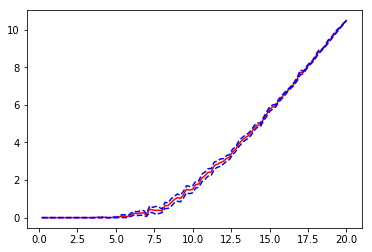

In [120]:
import matplotlib.pyplot as plt

S0 = np.linspace(0,20,101)
call = Call(S0, 10, 0.5, 0.5, 0.1, 100)

V, lower_interval, upper_interval = call.price(type = 'control')

plt.plot(S0, V, color = 'red')
plt.plot(S0, lower_interval, color = 'b', linestyle = 'dashed')
plt.plot(S0, upper_interval, color = 'b', linestyle = 'dashed')